# **0. 개요**

### 웹 로그 기반 조회수 예측 해커톤
(https://dacon.io/competitions/official/236226/overview/description)


### <주제>
웹 로그 데이터를 기반으로 조회수 예측

### <설명>
다양한 웹 로그를 활용하여 한 세션에서 발생하는 조회수를 예측

### <Dataset Info.>

**Feature name** | **Feature 정보**
--- | ---
**sessionID** | 세션 ID
**userID** | 사용자 ID
**TARGET** | 세션에서 발생한 총 조회수
**browser** | 사용된 브라우저
**OS** | 사용된 기기의 운영체제
**device** | 사용된 기기
**new** | 첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)
**quality** | 세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)
**duration** | 총 세션 시간 (단위: 초)
**bounced** | 이탈 여부 (0: 이탈하지 않음, 1: 이탈함)
**transaction** | 세션 내에서 발생의 거래의 수
**transaction_revenue** | 총 거래 수익
**continent** | 세션이 발생한 대륙
**subcontinent** | 세션이 발생한 하위 대륙
**country** | 세션이 발생한 국가
**traffic_source** | 트래픽이 발생한 소스
**traffic_medium** | 트래픽 소스의 매체
**keyword** | 트래픽 소스의 키워드, 일반적으로 traffic_medium이 organic, cpc인 경우에 설정
**referral_path** | traffic_medium이 referral인 경우 설정되는 경로

# **1. 라이브러리 불러오기**

In [2]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<ipython-input-2-45f6d3c2a187>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# **2. 데이터 로드 및 확인**

In [3]:
# 라이브러리 설치
!pip install gdrive_dataset

In [4]:
from gdrivedataset import loader

file_id = '1J2lTMmwoHT1Rm8Dbf-sQ9_DEvILA05B2'
loader.load_from_google_drive(file_id)

========== files ============

data/open



In [5]:
# train 및 test 데이터 불러오기
df_train = pd.read_csv('data/open/train.csv')
df_test = pd.read_csv('data/open/test.csv')

## **2.1. 훈련 데이터 (train set)**

In [6]:
# 데이터프레임 살펴보기
df_train.head()

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000


In [7]:
df_train.shape

(252289, 19)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sessionID            252289 non-null  object 
 1   userID               252289 non-null  object 
 2   TARGET               252289 non-null  float64
 3   browser              252289 non-null  object 
 4   OS                   252289 non-null  object 
 5   device               252289 non-null  object 
 6   new                  252289 non-null  int64  
 7   quality              252289 non-null  float64
 8   duration             252289 non-null  float64
 9   bounced              252289 non-null  int64  
 10  transaction          252289 non-null  float64
 11  transaction_revenue  252289 non-null  float64
 12  continent            252289 non-null  object 
 13  subcontinent         252289 non-null  object 
 14  country              252289 non-null  object 
 15  traffic_source   

In [9]:
# 결측치 수 확인
df_train.isnull().sum()

sessionID                   0
userID                      0
TARGET                      0
browser                     0
OS                          0
device                      0
new                         0
quality                     0
duration                    0
bounced                     0
transaction                 0
transaction_revenue         0
continent                   0
subcontinent                0
country                     0
traffic_source              0
traffic_medium              0
keyword                137675
referral_path          161107
dtype: int64

**Observations:**
* df_train은 총 252,289개의 행과 19개의 열로 구성되어 있는 데이터임. 그중 featrue 16개 (sessionID와 userID 제외), target label 1개로 구성되어 있음.
* Feature는 총 16개중 6개의 수치형 데이터와 10개의 범주형 데이터로 구성되어 있음.
* Target label은 수치형 데이터임.
* keyword와 referral_path feature에 결측값이 각각 137,675개, 161,107개가 있음.

### **2.1.1. 수치형 데이터**

In [10]:
# 수치형 데이터 통계값 확인
df_train.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


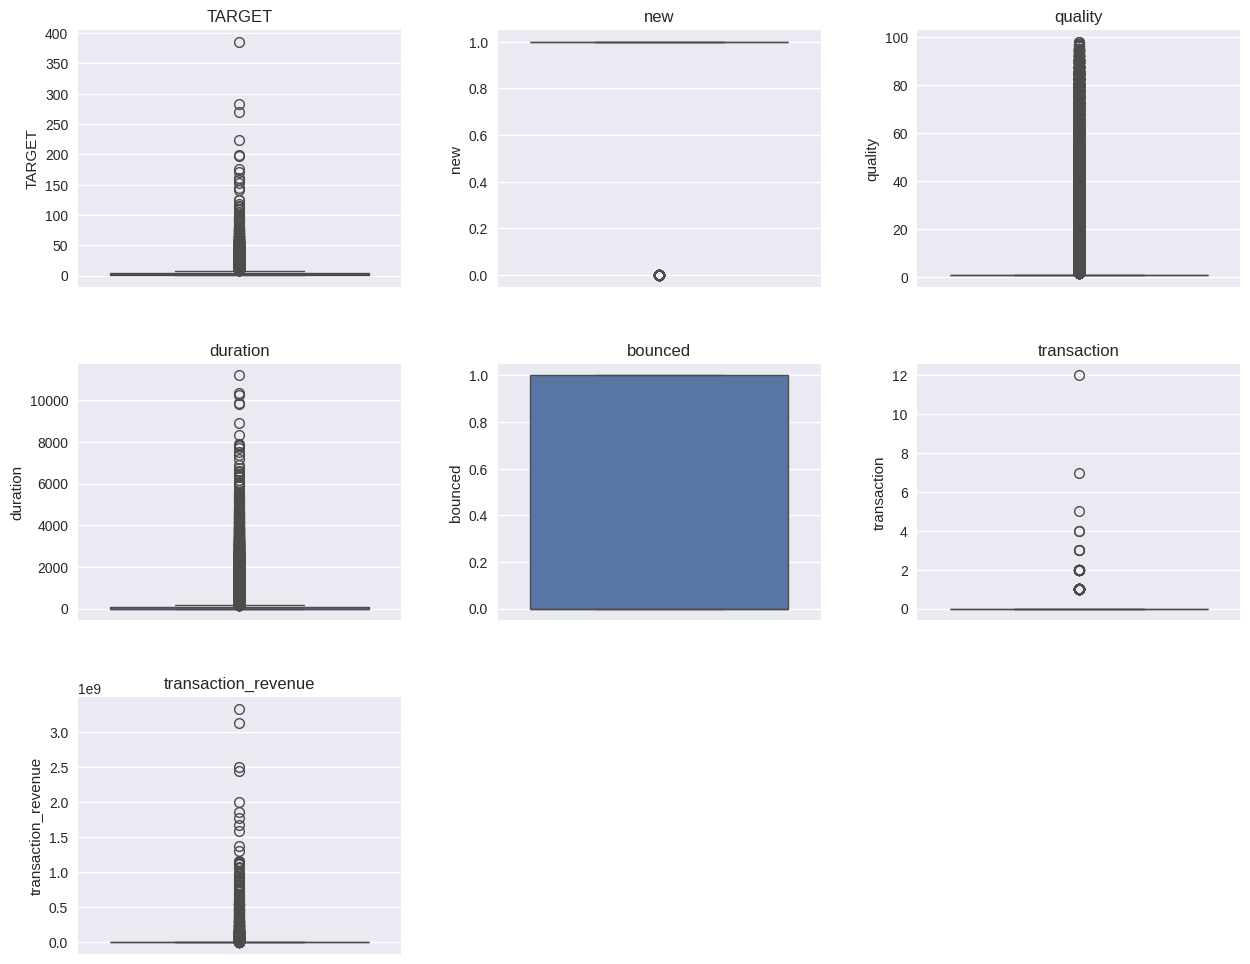

In [11]:
# 수치형 데이터 컬럼명 추출
num_cols = df_train.select_dtypes(include="number").columns

# 수치형 데이터 Boxplot
f, ax = plt.subplots(3, 3, figsize = (15,12))

i = 0
for row in range(3):
    for col in range(3):
        if i < 7:
            sns.boxplot(df_train, y = num_cols[i], ax = ax[row, col])
            ax[row, col].set_title(num_cols[i])
            i += 1
        else:
            ax[row, col].set_visible(False)

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

**Observations:**
* quality, duration, transaction, transaction_revenue는 0 부근에 데이터가 집중되어 있음.
* new는 1 부근에 데이터가 집중(50%이상)되어 있기 때문에 처음 방문하는 사람이 많은 것으로 보임.
* bonnced는 중앙값까지의 데이터가 0 (이탈하지 않음)에 분포해 있음.

### **2.1.2. 범주형 데이터**

In [12]:
# 범주형 데이터 컬럼명 추출
cat_cols = df_train.select_dtypes(include="object").columns
cat_cols

Index(['sessionID', 'userID', 'browser', 'OS', 'device', 'continent',
       'subcontinent', 'country', 'traffic_source', 'traffic_medium',
       'keyword', 'referral_path'],
      dtype='object')

In [13]:
# 범주형 데이터 내 데이터 확인
for i in range(2,len(cat_cols)-2):  # sessionID와 userID 제외
    print(f'{cat_cols[i]}: {len(df_train[cat_cols[i]].unique())}개')

browser: 70개
OS: 21개
device: 3개
continent: 6개
subcontinent: 23개
country: 205개
traffic_source: 168개
traffic_medium: 7개


**Observations:**
* device와 continent,traffic_medium을 제외한 feature의 범주수가 10개 이상임.

## **2.2. 시험 데이터 (test set)**

In [14]:
# 데이터프레임 살펴보기
df_test.head()

,sessionID,userID,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_252289,USER_206024,Chrome,Linux,desktop,1,75.0,698.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
1,SESSION_252290,USER_206025,Safari,iOS,tablet,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
2,SESSION_252291,USER_206026,Chrome,Windows,desktop,1,1.0,33.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NaN,Category2_Path_0082
3,SESSION_252292,USER_206027,Chrome,Android,mobile,1,1.0,76.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
4,SESSION_252293,USER_206028,Internet Explorer,Windows Phone,mobile,1,2.0,372.0,0,0.0,0.0,Asia,Southern Asia,India,youtube.com,referral,NaN,Category11_Path_0088


In [15]:
df_test.shape

(79786, 18)

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79786 entries, 0 to 79785
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sessionID            79786 non-null  object 
 1   userID               79786 non-null  object 
 2   browser              79786 non-null  object 
 3   OS                   79786 non-null  object 
 4   device               79786 non-null  object 
 5   new                  79786 non-null  int64  
 6   quality              79786 non-null  float64
 7   duration             79786 non-null  float64
 8   bounced              79786 non-null  int64  
 9   transaction          79786 non-null  float64
 10  transaction_revenue  79786 non-null  float64
 11  continent            79786 non-null  object 
 12  subcontinent         79786 non-null  object 
 13  country              79786 non-null  object 
 14  traffic_source       79786 non-null  object 
 15  traffic_medium       79786 non-null 

In [17]:
# 결측치 수 확인
df_test.isnull().sum()

sessionID                  0
userID                     0
browser                    0
OS                         0
device                     0
new                        0
quality                    0
duration                   0
bounced                    0
transaction                0
transaction_revenue        0
continent                  0
subcontinent               0
country                    0
traffic_source             0
traffic_medium             0
keyword                43070
referral_path          53891
dtype: int64

**Observations:**
* df_train은 총 79,786개의 행과 18개의 열로 구성되어 있는 데이터임. 그중 featrue 16개 (sessionID와 userID 제외)임.
* keyword와 referral_path feature에 결측값이 각각 43,070개, 53,891개가 있음.

    -> test와 train에 모두 결측값이 있는 것으로 보아 NaN이 결측값이 아닌 하나의 범주인 것으로 보임.

### **2.2.1. 수치형 데이터**

In [18]:
# 수치형 데이터 통계값 확인
df_test.describe()

,new,quality,duration,bounced,transaction,transaction_revenue
count,79786.000000,79786.000000,79786.000000,79786.000000,79786.000000,7.978600e+04
mean,0.734515,3.967576,121.550635,0.496804,0.007909,9.552892e+05
std,0.441594,11.349192,349.168791,0.499993,0.095260,2.714007e+07
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000e+00
75%,1.000000,1.000000,75.000000,1.000000,0.000000,0.000000e+00
max,1.000000,98.000000,9316.000000,1.000000,7.000000,4.609835e+09


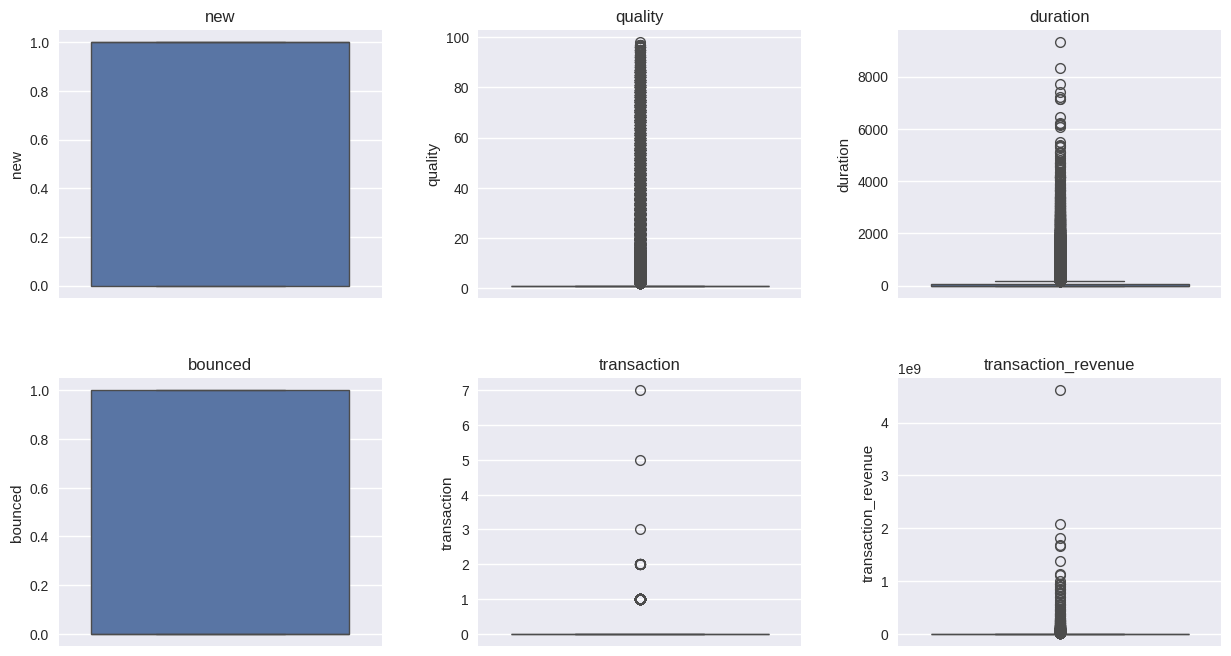

In [19]:
# 수치형 데이터 컬럼명 추출
num_cols = df_test.select_dtypes(include="number").columns

# 수치형 데이터 Boxplot
f, ax = plt.subplots(2, 3, figsize = (15,8))

i = 0
for row in range(2):
    for col in range(3):
        sns.boxplot(df_test, y = num_cols[i], ax = ax[row, col])
        ax[row, col].set_title(num_cols[i])
        i += 1

plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

**Observations:**
* quality, duration, transaction, transaction_revenue는 0 부근에 데이터가 집중되어 있으며, train data와 유사한 데이터 분포를 보임.
* new는 50%이상의 데이터가 1에 분포되어 있기 때문에 처음 방문하는 사람의 수가 더 많음
* bonnced는 50% 이상의 데이터가 0 (이탈하지 않음)에 분포해 있음.

### **2.2.2. 범주형 데이터**

In [20]:
# 범주형 데이터 컬럼명 추출
cat_cols = df_test.select_dtypes(include="object").columns
cat_cols

Index(['sessionID', 'userID', 'browser', 'OS', 'device', 'continent',
       'subcontinent', 'country', 'traffic_source', 'traffic_medium',
       'keyword', 'referral_path'],
      dtype='object')

In [21]:
# 범주형 데이터 내 데이터 확인
for i in range(2,len(cat_cols)-2):  # sessionID와 userID 제외
    print(f'{cat_cols[i]}: {len(df_test[cat_cols[i]].unique())}개')

browser: 45개
OS: 16개
device: 3개
continent: 6개
subcontinent: 23개
country: 192개
traffic_source: 97개
traffic_medium: 7개


**Observations:**
* train 데이터와 마찬가지로 device와 continent,traffic_medium을 제외한 feature의 범주수가 10개 이상임.
* test 데이터의 device와 continent,traffic_medium의 범주수는 train 데이터와 동일하지만, 나머지 feature의 범주 수는 다름. Feature engineering 단계에서 새로운 범주로 나누어 간소화시키는 것에 대한 검토가 필요해 보임.

# **3. EDA**

## **3.1. 수치형 데이터**

In [22]:
df_train.select_dtypes(include="number").columns

Index(['TARGET', 'new', 'quality', 'duration', 'bounced', 'transaction',
       'transaction_revenue'],
      dtype='object')

### **3.1.1 Target**
세션에서 발생한 총 조회수

In [23]:
df_train['TARGET'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: TARGET
Non-Null Count   Dtype  
--------------   -----  
252289 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [24]:
df_train['TARGET'].describe()

count    252289.000000
mean          3.592626
std           5.509465
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         386.000000
Name: TARGET, dtype: float64

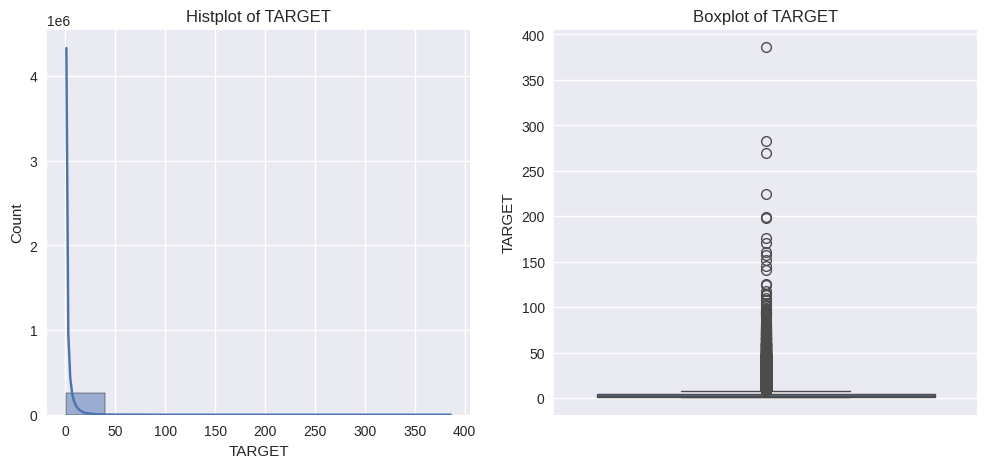

In [25]:
f, ax = plt.subplots(1,2, figsize = (12,5))

sns.histplot(x='TARGET', data = df_train, bins = 10, kde = True, ax = ax[0])
ax[0].set_title('Histplot of TARGET')
sns.boxplot(y='TARGET', data = df_train, ax = ax[1])
ax[1].set_title('Boxplot of TARGET')
plt.show()

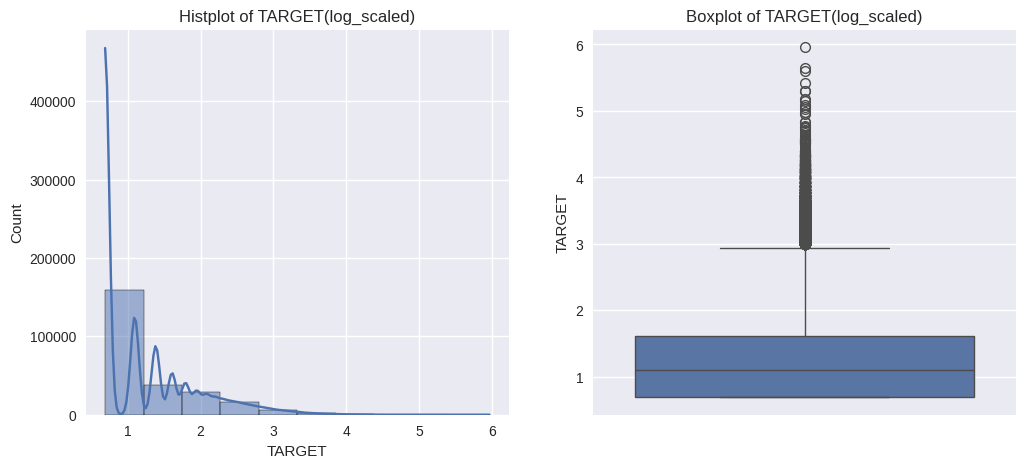

In [26]:
# Log 변환 후, plot
df2 = df_train.copy()
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))

f, ax = plt.subplots(1,2, figsize = (12,5))
sns.histplot(x='TARGET', data = df2, bins = 10, kde = True, ax = ax[0])
ax[0].set_title('Histplot of TARGET(log_scaled)')
sns.boxplot(y='TARGET', data = df2, ax = ax[1])
ax[1].set_title('Boxplot of TARGET(log_scaled)')
plt.show()

**Observations:**
* TARGET은 target label로 test 데이터를 이용하여 예측해야 하는 값임.
* TARGET의 데이터 분포를 보면, 3분위 수가 4.0이고 최대값은 386.0이기 때문에, 3분위수~최대값 사이에 넓은 분포의 데이타가 있음을 알 수 있음.
* 데이터가 왼쪽으로 편중(Positively skewed)되어 있기 때문에 훈련 과정에서 모델의 성능에 영향을 줄 것으로 생각됨. Log 처리를 해서 훈련하는 것이 필요해 보임.

### **3.1.2 new**
첫 방문 여부 (0: 첫 방문 아님, 1: 첫 방문)

In [27]:
df_train['new'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: new
Non-Null Count   Dtype
--------------   -----
252289 non-null  int64
dtypes: int64(1)
memory usage: 1.9 MB


In [28]:
df_train['new'].describe()

count    252289.000000
mean          0.751955
std           0.431879
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

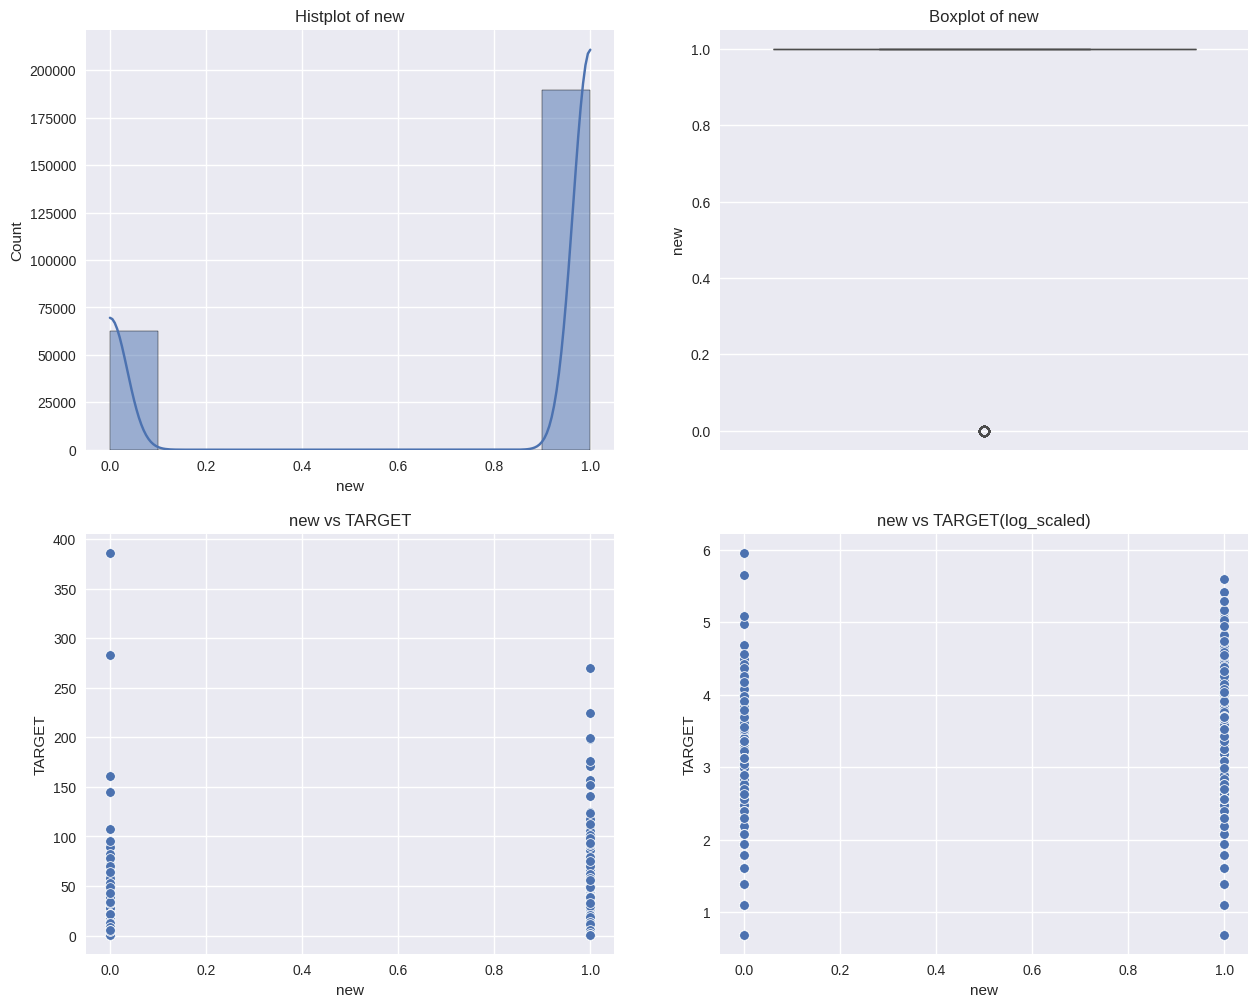

In [29]:
f, ax = plt.subplots(2,2, figsize = (15,12))

sns.histplot(x='new', data = df_train, bins = 10, kde = True, ax = ax[0,0])
ax[0,0].set_title('Histplot of new')
sns.boxplot(y='new', data = df_train, ax = ax[0,1])
ax[0,1].set_title('Boxplot of new')
sns.scatterplot(x = 'new', y = 'TARGET', data = df_train, ax = ax[1,0])
ax[1,0].set_title('new vs TARGET')

df2 = df_train.copy()
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))
sns.scatterplot(x = 'new', y = 'TARGET', data = df2, ax = ax[1,1])
ax[1,1].set_title('new vs TARGET(log_scaled)')

plt.show()

In [30]:
df_train.groupby('new')[['TARGET']].agg(['count','mean', 'median'])

TARGET                 
      count      mean median
new                         
0     62579  4.231579    2.0
1    189710  3.381857    1.0

In [31]:
df2.groupby('new')[['TARGET']].agg(['count','mean', 'median'])

TARGET                    
      count      mean    median
new                            
0     62579  1.307533  1.098612
1    189710  1.185667  0.693147

**Observations:**
* new feature는 0과 1로만 이루어진 feature로 0은 첫방문이 아닌 경우, 1은 첫방문인 경우를 의미함.
* Train data의 new feature는 0 24.8%, 1은 75.2%의 비율로 구성되어 있음.
* 첫방문인 경우의(new==1) 조회수(TARGET)의 평균과 중앙값이 첫방문이 아닌 경우(new==0)인 경우 대비 조회수의 평균값이 낮음. 첫방문 여부가 조회수에 영향을 주는 것으로 보임.

### **3.1.3 quality**
세션의 질 (거래 성사를 기준으로 측정된 값, 범위: 1~100)

In [32]:
df_train['quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: quality
Non-Null Count   Dtype  
--------------   -----  
252289 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [33]:
df_train['quality'].describe()

count    252289.000000
mean          3.816805
std          11.091028
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          98.000000
Name: quality, dtype: float64

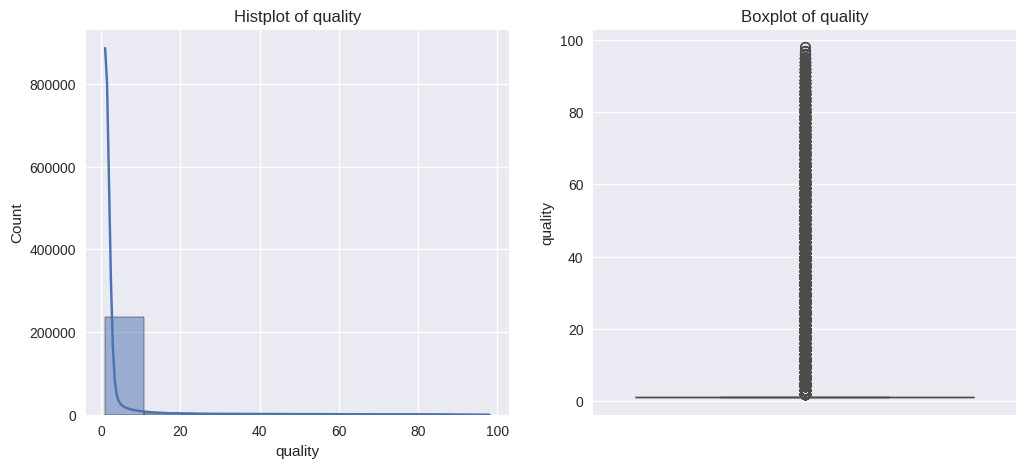

In [34]:
f, ax = plt.subplots(1,2, figsize = (12,5))

sns.histplot(x='quality', data = df_train, bins = 10, kde = True, ax = ax[0])
ax[0].set_title('Histplot of quality')
sns.boxplot(y='quality', data = df_train, ax = ax[1])
ax[1].set_title('Boxplot of quality')

plt.show()

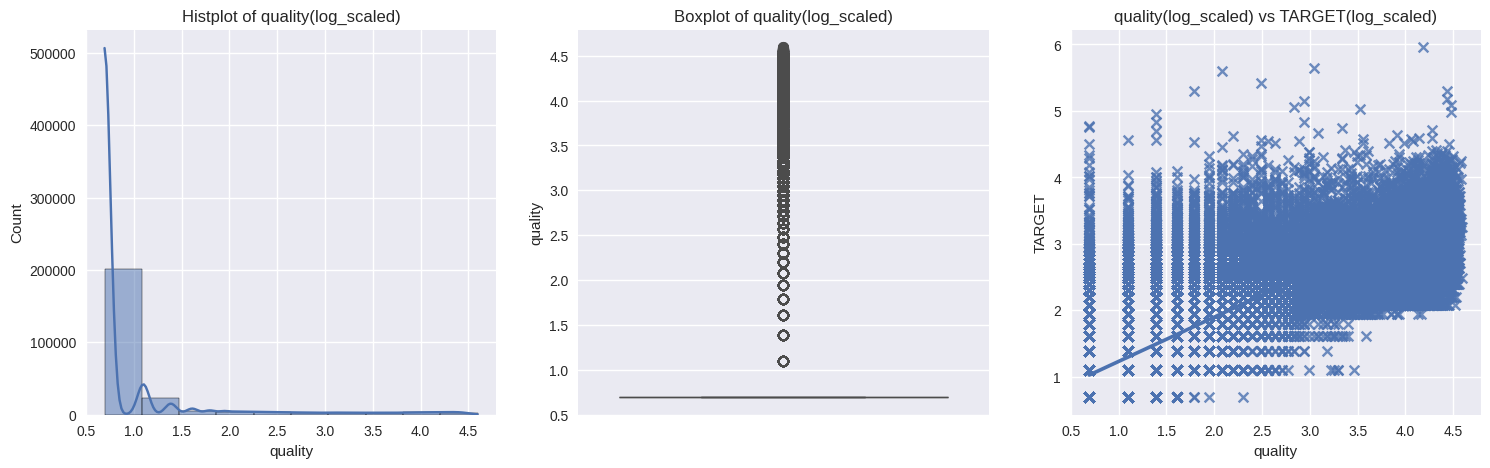

In [35]:
# Log 변환 후, plot
df2 = df_train.copy()
df2['quality'] = df2['quality'].map(lambda i : np.log1p(i))
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))

f, ax = plt.subplots(1,3, figsize = (18,5))
sns.histplot(x='quality', data = df2, bins = 10, kde = True, ax = ax[0])
ax[0].set_title('Histplot of quality(log_scaled)')
sns.boxplot(y='quality', data = df2, ax = ax[1])
ax[1].set_title('Boxplot of quality(log_scaled)')
sns.regplot(x = 'quality', y = 'TARGET', data = df2, marker="x", ax = ax[2])
ax[2].set_title('quality(log_scaled) vs TARGET(log_scaled)')

plt.show()

**Observations:**
* quality feature 0-98사이의 데이터로 구성되어 있으며, 대부분의 데이터는 0-1사이에 분포하고 있음.
* 데이터가 왼쪽으로 편중(Positively skewed)되어 있기 때문에 훈련 과정에서 모델의 성능에 영향을 줄 것으로 생각됨. Log 처리를 해서 훈련하는 것이 필요해 보임.
* Log 처리 후, TARGET feature과의 관계를 보면 quality가 증가할수록 조회수가 증가하는 경향으로 보임.

### **3.1.4 duration**
총 세션 시간 (단위: 초)

In [36]:
df_train['duration'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: duration
Non-Null Count   Dtype  
--------------   -----  
252289 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [37]:
df_train['duration'].describe()

count    252289.000000
mean        113.104253
std         330.876019
min           0.000000
25%           0.000000
50%           3.000000
75%          71.000000
max       11186.000000
Name: duration, dtype: float64

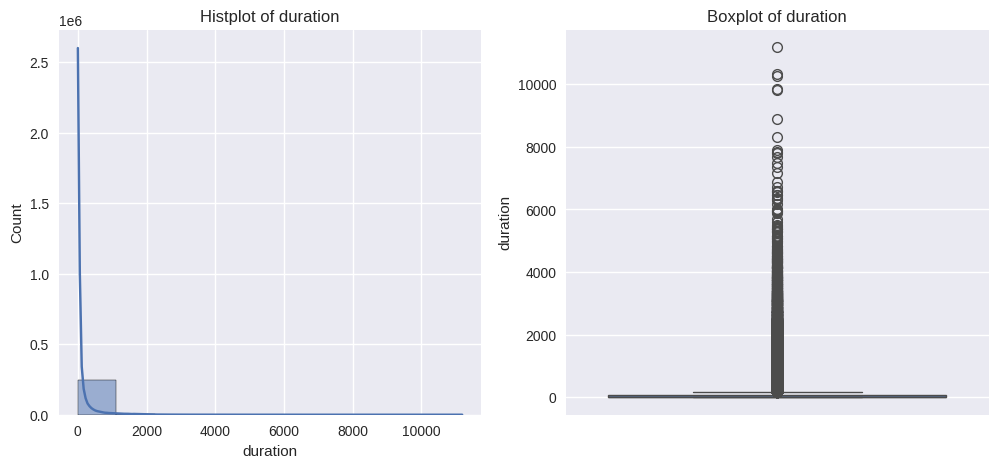

In [38]:
f, ax = plt.subplots(1,2, figsize = (12,5))

sns.histplot(x='duration', data = df_train, bins = 10, kde = True, ax = ax[0])
ax[0].set_title('Histplot of duration')
sns.boxplot(y='duration', data = df_train, ax = ax[1])
ax[1].set_title('Boxplot of duration')
plt.show()

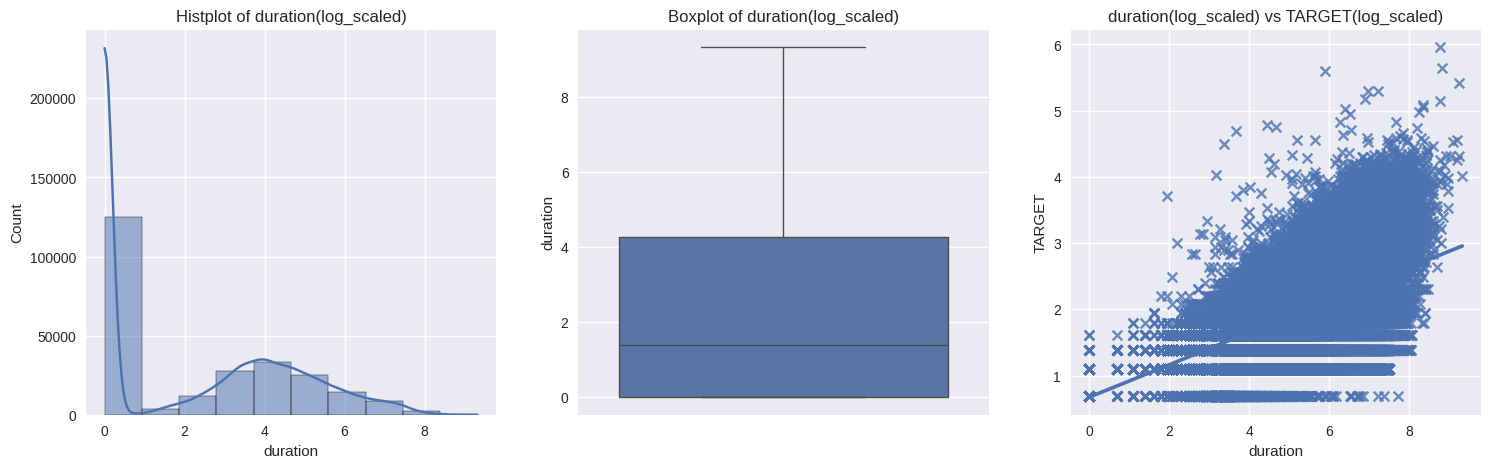

In [39]:
# Log 변환 후, plot
df2 = df_train.copy()
df2['duration'] = df2['duration'].map(lambda i : np.log1p(i))
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))

f, ax = plt.subplots(1,3, figsize = (18,5))
sns.histplot(x='duration', data = df2, bins = 10, kde = True, ax = ax[0])
ax[0].set_title('Histplot of duration(log_scaled)')
sns.boxplot(y='duration', data = df2, ax = ax[1])
ax[1].set_title('Boxplot of duration(log_scaled)')
sns.regplot(x = 'duration', y = 'TARGET', data = df2, marker="x", ax = ax[2])
ax[2].set_title('duration(log_scaled) vs TARGET(log_scaled)')

plt.show()

**Observations:**
* duration feature는 데이터의 50%가 3.0이하, 75% 71.0이하에 분포하고 있으며, 나머지 25%는 71.0-11,186 사이에 분포해있음.
* 데이터가 왼쪽으로 편중(Positively skewed)되어 있기 때문에 훈련 과정에서 모델의 성능에 영향을 줄 것으로 생각됨. Log 처리 후 데이터 분포도가 log 처리 이전 대비 개선되는 것으로 보임.
* Log 처리 후, TARGET feature과의 관계를 보면 duration이 증가할수록 조회수가 증가하는 경향으로 보임.

### **3.1.5 bounced**
이탈 여부 (0: 이탈하지 않음, 1: 이탈함)

In [40]:
df_train['bounced'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: bounced
Non-Null Count   Dtype
--------------   -----
252289 non-null  int64
dtypes: int64(1)
memory usage: 1.9 MB


In [41]:
df_train['bounced'].describe()

count    252289.000000
mean          0.493672
std           0.499961
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: bounced, dtype: float64

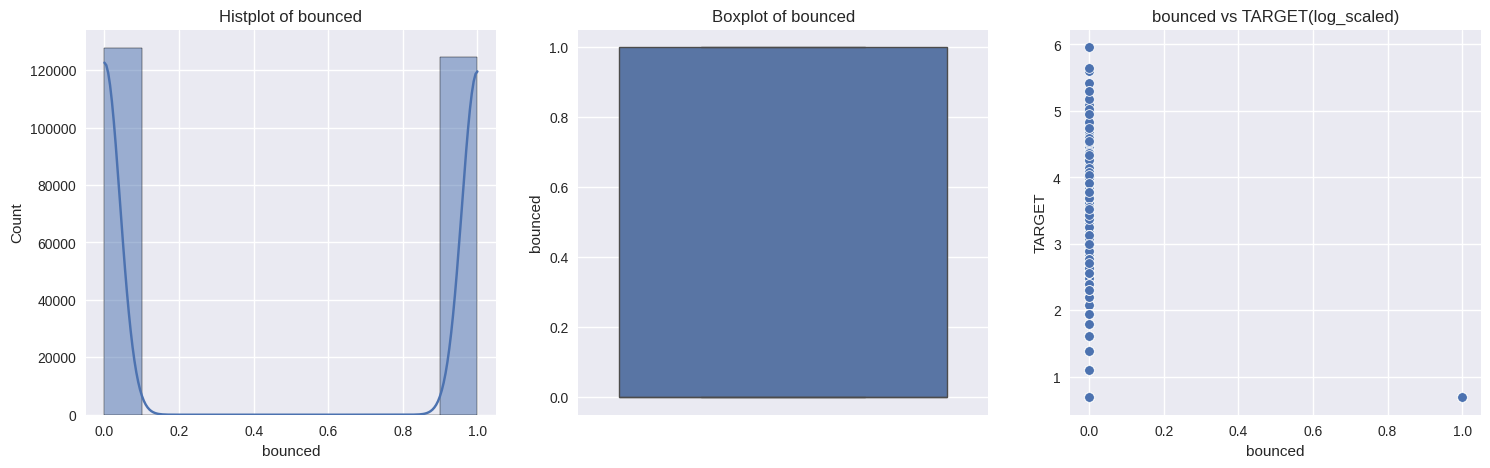

In [42]:
f, ax = plt.subplots(1,3, figsize = (18,5))

sns.histplot(x='bounced', data = df_train, bins = 10, kde = True, ax = ax[0])
ax[0].set_title('Histplot of bounced')
sns.boxplot(y='bounced', data = df_train, ax = ax[1])
ax[1].set_title('Boxplot of bounced')

df2 = df_train.copy()
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))
sns.scatterplot(x = 'bounced', y = 'TARGET', data = df2, ax = ax[2])
ax[2].set_title('bounced vs TARGET(log_scaled)')

plt.show()

In [43]:
df2.groupby('bounced')['TARGET'].agg(['mean','median'])

,mean,median
bounced,,
0,1.725576,1.609438
1,0.693147,0.693147


**Observations:**
* bounced는 0과 1로 이루어진 feature로 0은 이탈하지 않음, 1은 이탈함을 의미함.
* 0과 1의 비율은 유사한 수준으로 분포하고 있음.
* 이탈 여부가 1인 경우 조회수가 0이며, 이탈 여부가 0인 경우 0~6까지 넓게 분포하고 있음. bounced 값은 조회수에 영향을 주는 feature로 보임.

### **3.1.6 transaction**
세션 내에서 발생의 거래의 수

In [44]:
df_train['transaction'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: transaction
Non-Null Count   Dtype  
--------------   -----  
252289 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [45]:
df_train['transaction'].describe()

count    252289.000000
mean          0.009033
std           0.100938
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: transaction, dtype: float64

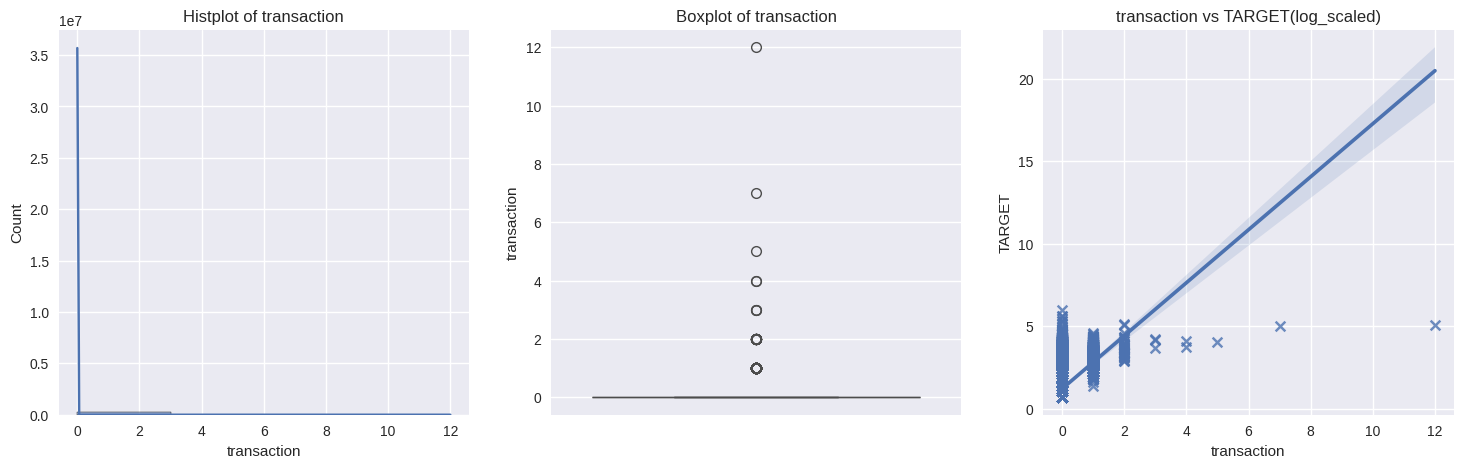

In [46]:
f, ax = plt.subplots(1,3, figsize = (18,5))


sns.histplot(x='transaction', data = df_train, bins = 4, kde = True, ax = ax[0])
ax[0].set_title('Histplot of transaction')
sns.boxplot(y='transaction', data = df_train, ax = ax[1])
ax[1].set_title('Boxplot of transaction')

df2 = df_train.copy()
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))
sns.regplot(x = 'transaction', y = 'TARGET', data = df2, marker="x", ax = ax[2])
ax[2].set_title('transaction vs TARGET(log_scaled)')

plt.show()

**Observations:**
* transaction feature는 0~12 사이의 데이터를 갖고 있으며, 대부분의 데이터가 0에 분포해있음.
* transaction이 증가할수록 log scaled TARGET의 분포가 소폭 상승하는 경향임.

### **3.1.7 transaction_revenue**
총 거래 수익

In [47]:
df_train['transaction_revenue'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252289 entries, 0 to 252288
Series name: transaction_revenue
Non-Null Count   Dtype  
--------------   -----  
252289 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [48]:
df_train['transaction_revenue'].describe()

count    2.522890e+05
mean     9.061248e+05
std      2.127689e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.325712e+09
Name: transaction_revenue, dtype: float64

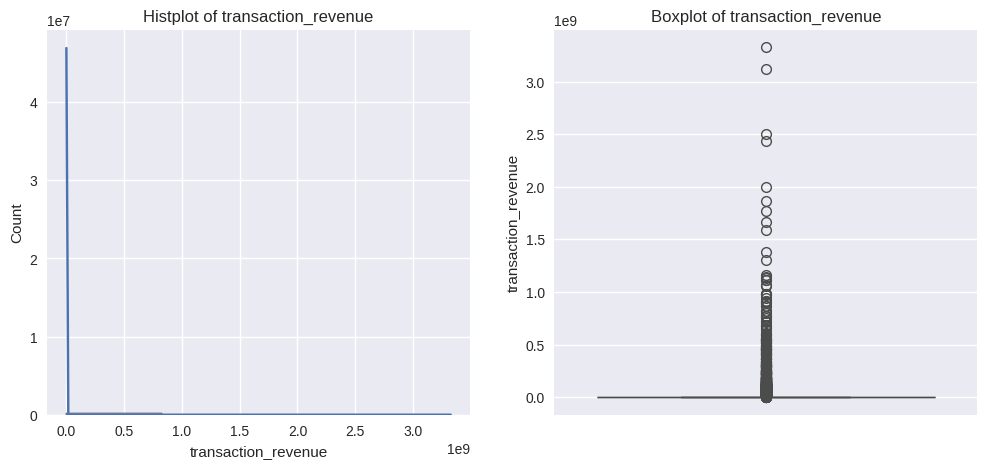

In [49]:
f, ax = plt.subplots(1,2, figsize = (12,5))
sns.histplot(x='transaction_revenue', data = df_train, bins = 4, kde = True, ax = ax[0])
ax[0].set_title('Histplot of transaction_revenue')
sns.boxplot(y='transaction_revenue', data = df_train, ax = ax[1])
ax[1].set_title('Boxplot of transaction_revenue')
plt.show()

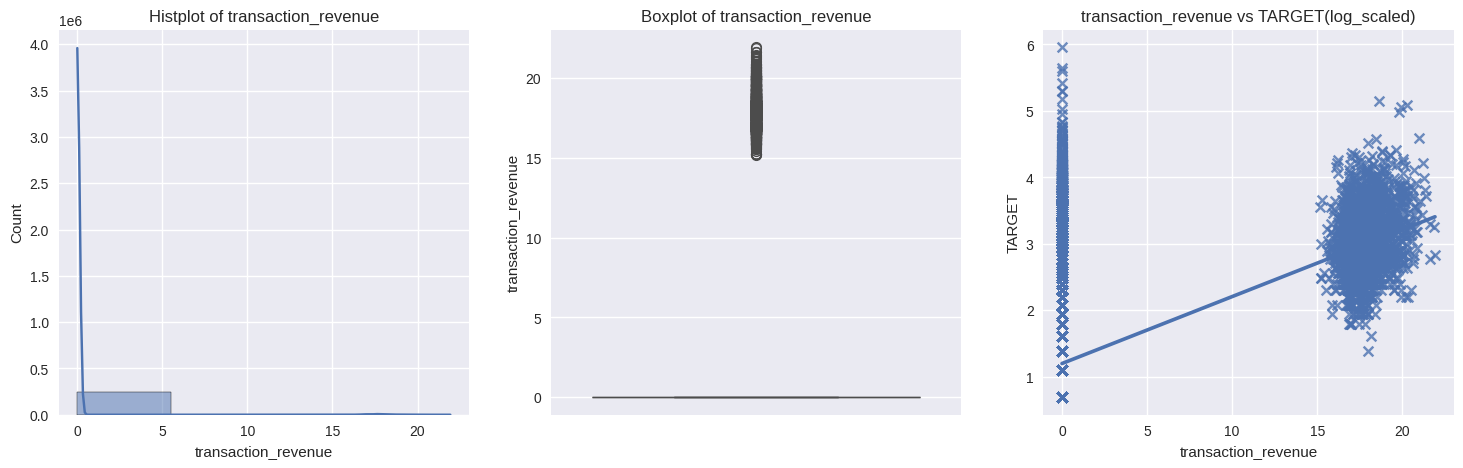

In [50]:
f, ax = plt.subplots(1,3, figsize = (18,5))

df2 = df_train.copy()
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))
df2['transaction_revenue'] = df2['transaction_revenue'].map(lambda i : np.log1p(i))

sns.histplot(x='transaction_revenue', data = df2, bins = 4, kde = True, ax = ax[0])
ax[0].set_title('Histplot of transaction_revenue')
sns.boxplot(y='transaction_revenue', data = df2, ax = ax[1])
ax[1].set_title('Boxplot of transaction_revenue')
sns.regplot(x = 'transaction_revenue', y = 'TARGET', data = df2, marker="x", ax = ax[2])
ax[2].set_title('transaction_revenue vs TARGET(log_scaled)')

plt.show()

**Observations:**
* transaction_revenue는 매우 넓은 범위를 갖고 있는 feature임.
* log 변환을 하는 경우 데이터가 2개의 큰 그룹으로 나누어짐.

### **3.1.8 수치형 변수 간 상관계수**

<Axes: >

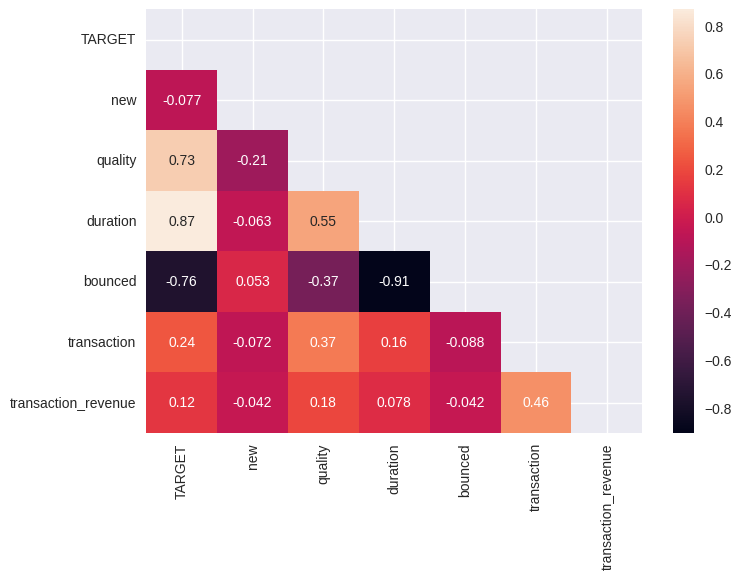

In [51]:
df2 = df_train.copy()
# 로그 변환
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))
df2['quality'] = df2['quality'].map(lambda i : np.log1p(i))
df2['duration'] = df2['duration'].map(lambda i : np.log1p(i))

data = np.random.rand(7, 7)
mask = np.triu(np.ones_like(data, dtype=bool))

sns.heatmap(df2.corr(), annot = True, mask = mask)

**Observations:**
* TARGET과 bounced, log scaled quality, log scaled duration의 상관관계가 높음. 이는 TARGET을 예측하는데 큰 영향을 줄 것으로 보임.
* 반면, new, transaction, transaction_revenue feature와 TARGET 간의 상관관계는 낮음.

## **3.2. 범주형 데이터**

In [52]:
df_train.select_dtypes(include="object").columns

Index(['sessionID', 'userID', 'browser', 'OS', 'device', 'continent',
       'subcontinent', 'country', 'traffic_source', 'traffic_medium',
       'keyword', 'referral_path'],
      dtype='object')

### **3.2.1 browser**

In [53]:
df_train['browser'].unique()

array(['Chrome', 'Samsung Internet', 'Firefox', 'Opera',
       'Safari (in-app)', 'Edge', 'Safari', 'Android Webview',
       'UC Browser', 'Internet Explorer', 'Opera Mini', 'BlackBerry',
       'Android Browser', 'Amazon Silk', 'Coc Coc', 'YaBrowser',
       'Nintendo Browser', 'Nokia Browser', 'MRCHROME', 'Puffin',
       'Mozilla Compatible Agent', 'Maxthon', '+Simple Browser',
       'Apple-iPhone7C2', 'Playstation Vita Browser',
       'osee2unifiedRelease', 'SAMSUNG-SM-B355E Opera', 'DESKTOP', 'Iron',
       'Browser', 'rpfanjzoxyemsgbtichqkudwlv',
       'cajrnbtvqwfkolzyxushpdgime', 'wvsmagudcqeytijorlhxnfzkbp',
       'efkaxnbyohqtspzlvcwrjmigdu', 'bsfnwveckhgpdoyjxmizruqtla',
       'Mozilla', 'Konqueror', 'Netscape', 'Amazon.com', 'SeaMonkey',
       ';__CT_JOB_ID__:76fd1acb-e365-43c0-b967-908bcf5d5b59;',
       'eosutpkiahjzvdgcwxlmyfqbrn', 'cnwmpegudakrqzljtvfxohbysi',
       'fspmihbxzowgnuctrqykjlvade', 'YE',
       ';__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb9183;

In [54]:
len(df_train['browser'].unique())

70

In [55]:
df_train['browser'].value_counts(ascending=False).head(20)/df_train.shape[0]

Chrome                      0.691251
Safari                      0.141461
Android Webview             0.054917
Firefox                     0.033438
Internet Explorer           0.018126
Edge                        0.014674
Samsung Internet            0.012196
Opera Mini                  0.012054
Safari (in-app)             0.007908
Opera                       0.005276
UC Browser                  0.003571
YaBrowser                   0.001593
Amazon Silk                 0.001019
Coc Coc                     0.000817
Mozilla Compatible Agent    0.000491
Android Browser             0.000436
Puffin                      0.000218
MRCHROME                    0.000059
Nokia Browser               0.000052
BlackBerry                  0.000052
Name: browser, dtype: float64

<Axes: xlabel='browser_trans', ylabel='TARGET'>

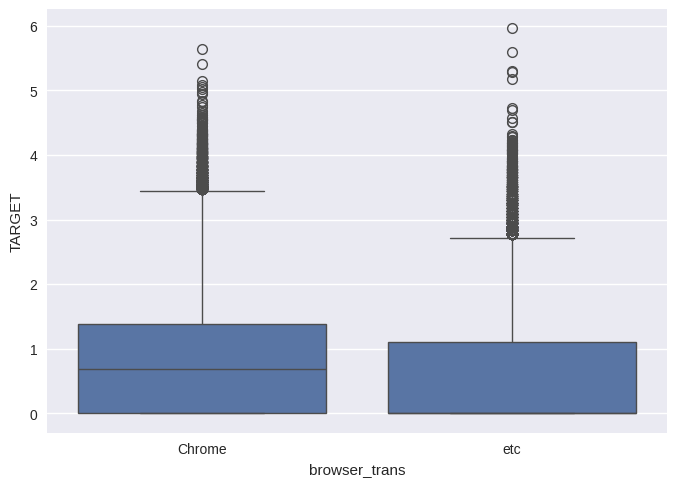

In [56]:
df2 = df_train.copy()
df2['browser_trans'] = 'etc'
df2['browser_trans'][df2['browser']=='Chrome'] = 'Chrome'
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)
sns.boxplot(y='TARGET', x = 'browser_trans', data = df2)

In [57]:
df2.groupby('browser_trans')['TARGET'].agg(['mean','median'])

,mean,median
browser_trans,,
Chrome,0.822504,0.693147
etc,0.590044,0.000000


**Observations:**
* browser feature는 70개의 범주로 이루어져 있으나, Chrome 범주가 69.1%를 차지하고 있음. 70개의 범주를 모두 다루는 것은 변수의 수가 너무 많아져 차원의 저주 문제를 일으킬 수 있음.
* 대부분의 데이터를 차지하는 Chrome과 그 이외의 범주들을 포함하는 etc로 나누고, log scaled TARGET과의 상관 관계를 확인한 결과 유의미한 경향을 확인할 수 있음. (Chrome은 TARGET의 평균과 중앙값이 etc 대비 높은 값을 보임.)

### **3.2.2 OS**

In [58]:
df_train['OS'].unique()

array(['Macintosh', 'Windows', 'Android', 'iOS', 'Linux', 'Tizen',
       'Chrome OS', 'BlackBerry', '(not set)', 'Xbox', 'Samsung',
       'Windows Phone', 'OS/2', 'Nintendo 3DS', 'Playstation Vita',
       'FreeBSD', 'SunOS', 'Nintendo WiiU', 'Firefox OS', 'SymbianOS',
       'Nokia'], dtype=object)

In [59]:
df_train['OS'].value_counts(ascending=False)/df_train.shape[0]

Windows             0.349278
Macintosh           0.239075
Android             0.205598
iOS                 0.118031
Linux               0.037901
Chrome OS           0.036553
(not set)           0.010274
Tizen               0.001272
Samsung             0.001027
Windows Phone       0.000507
OS/2                0.000143
Xbox                0.000123
BlackBerry          0.000115
Playstation Vita    0.000036
Nintendo 3DS        0.000024
Firefox OS          0.000016
FreeBSD             0.000012
SunOS               0.000004
Nintendo WiiU       0.000004
SymbianOS           0.000004
Nokia               0.000004
Name: OS, dtype: float64

<Axes: xlabel='OS_trans', ylabel='TARGET'>

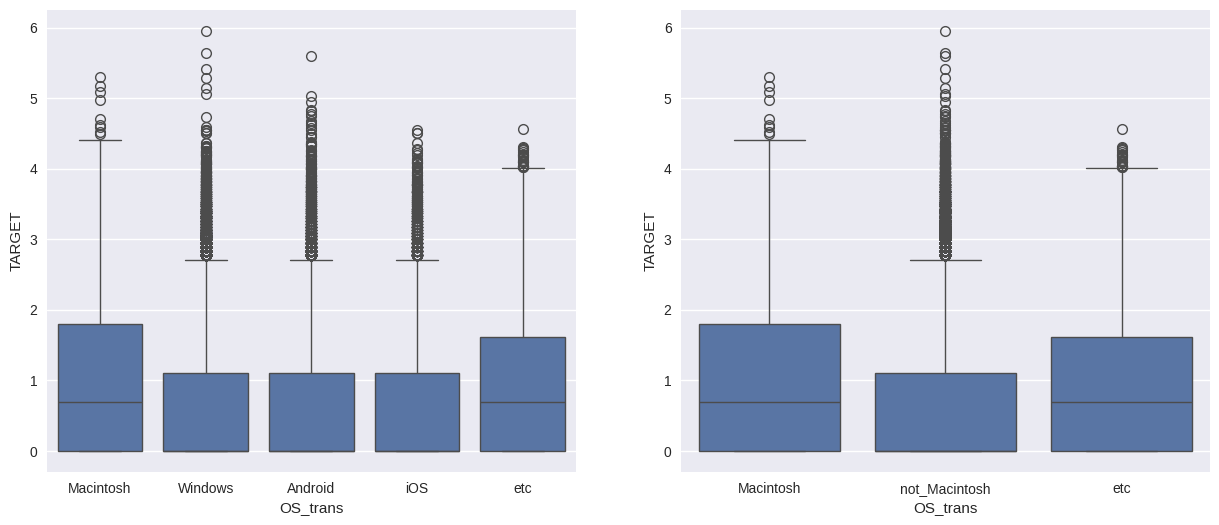

In [60]:
f, ax = plt.subplots(1,2, figsize = (15,6))

df2 = df_train.copy()
df2['OS_trans'] = 'etc'
df2['OS_trans'][df2['OS']=='Windows'] = 'Windows'
df2['OS_trans'][df2['OS']=='Macintosh'] = 'Macintosh'
df2['OS_trans'][df2['OS']=='Android'] = 'Android'
df2['OS_trans'][df2['OS']=='iOS'] = 'iOS'
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)
sns.boxplot(y='TARGET', x = 'OS_trans', data = df2, ax = ax[0])

df2 = df_train.copy()
df2['OS_trans'] = 'etc'
df2['OS_trans'][df2['OS']=='Windows'] = 'not_Macintosh'
df2['OS_trans'][df2['OS']=='Macintosh'] = 'Macintosh'
df2['OS_trans'][df2['OS']=='Android'] = 'not_Macintosh'
df2['OS_trans'][df2['OS']=='iOS'] = 'not_Macintosh'
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)
sns.boxplot(y='TARGET', x = 'OS_trans', data = df2, ax = ax[1])

In [61]:
df2.groupby('OS_trans')['TARGET'].agg(['mean','median'])

,mean,median
OS_trans,,
Macintosh,0.976646,0.693147
etc,0.907321,0.693147
not_Macintosh,0.649986,0.000000


**Observations:**
* OS feature는 21개의 feature로 이루어져 있음.
* 대부분의 데이터를 차지하고 있는 Windows, Macintosh, Android, iOS와 etc로 범주를 나눈 후 TARGET과의 상관 관계를 확인함. Macintosh와 etc., Windows, Android, iOS 간 유사한 평균, 중앙값을 보이며, 유사한 데이터 분포를 보임.

### **3.2.3 device**

In [62]:
df_train['device'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [63]:
df_train['device'].value_counts(ascending=False)/df_train.shape[0]

desktop    0.662466
mobile     0.303065
tablet     0.034468
Name: device, dtype: float64

<Axes: xlabel='device_trans', ylabel='TARGET'>

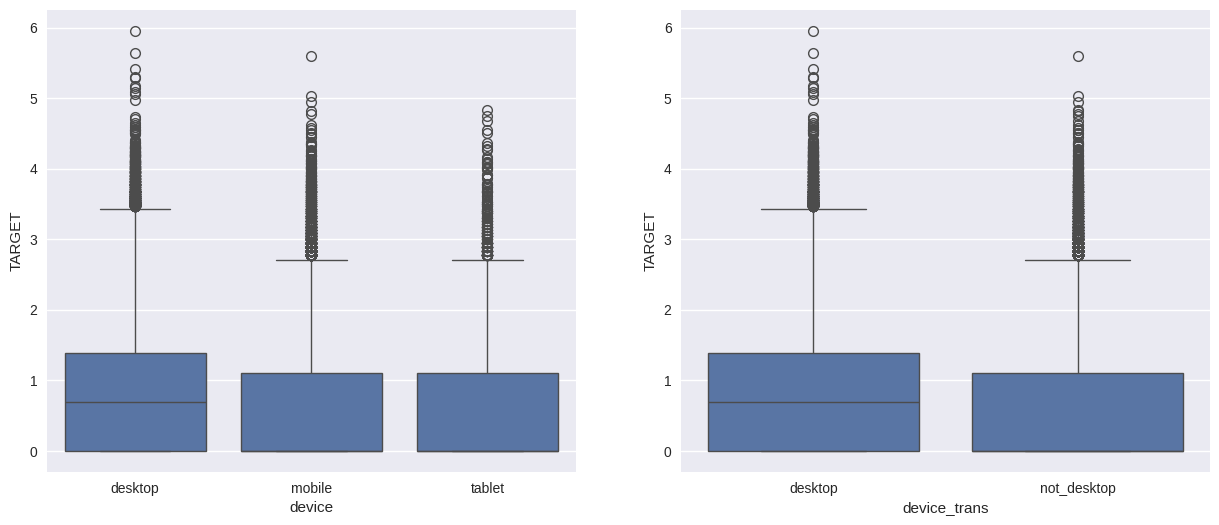

In [64]:
df2 = df_train.copy()

f, ax = plt.subplots(1,2, figsize = (15,6))

df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)
sns.boxplot(y='TARGET', x = 'device', data = df2, ax = ax[0])

df2['device_trans'] = 'not_desktop'
df2['device_trans'][df2['device']=='desktop'] = 'desktop'
sns.boxplot(y='TARGET', x = 'device_trans', data = df2, ax = ax[1])

In [65]:
df2.groupby('device')['TARGET'].agg(['mean','median'])

,mean,median
device,,
desktop,0.811189,0.693147
mobile,0.623366,0.000000
tablet,0.708663,0.000000


**Observations:**
* device feature는 3개의 범주로 이루어져 있음. desktop이 66.2%, mobile이 30.3%의 비율로 있으며, 나머지 3.4%가 tablet임.
* log scaled TARGET과의 상관 관계를 보면, mobile과 tablet은 유사한 평균과 중앙값, 데이터 분포를 갖고 있음.

### **3.2.4 continent**

In [66]:
df_train['continent'].unique()

array(['Americas', 'Europe', 'Asia', 'Africa', 'Oceania', '(not set)'],
      dtype=object)

In [67]:
df_train['continent'].value_counts(ascending=False)/df_train.shape[0]

Americas     0.501433
Asia         0.226938
Europe       0.213041
Africa       0.041674
Oceania      0.015581
(not set)    0.001332
Name: continent, dtype: float64

<Axes: xlabel='continent_trans', ylabel='TARGET'>

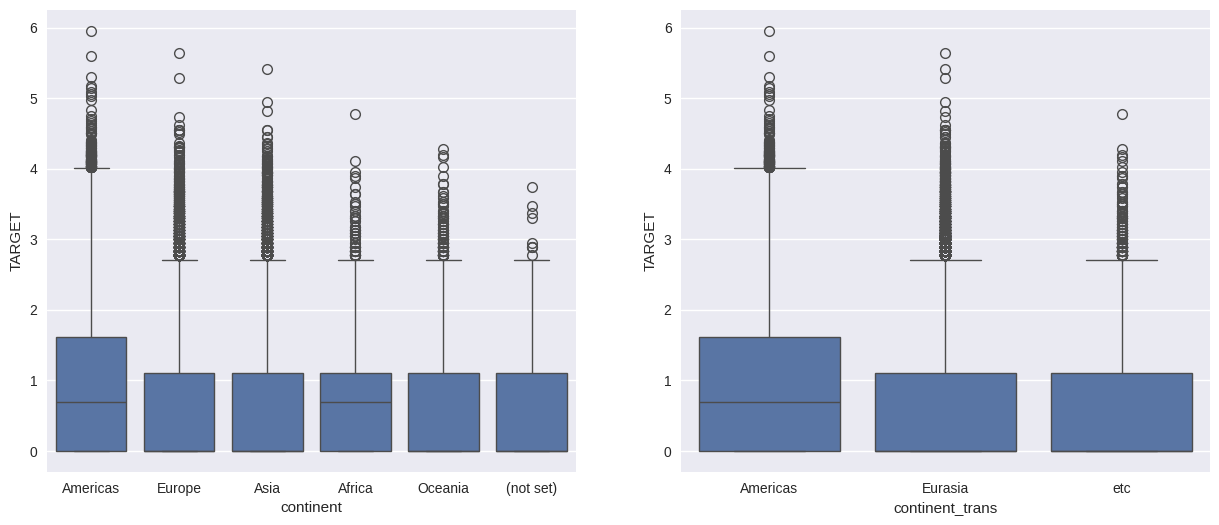

In [68]:
df2 = df_train.copy()

f, ax = plt.subplots(1,2, figsize = (15,6))

df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)
sns.boxplot(y='TARGET', x = 'continent', data = df2, ax = ax[0])

df2['continent_trans'] = 'etc'
df2['continent_trans'][df2['continent']=='Americas'] = 'Americas'
df2['continent_trans'][df2['continent']=='Asia'] = 'Eurasia'
df2['continent_trans'][df2['continent']=='Europe'] = 'Eurasia'
sns.boxplot(y='TARGET', x = 'continent_trans', data = df2, ax = ax[1])

In [69]:
df2.groupby('continent_trans')['TARGET'].agg(['mean','median'])

,mean,median
continent_trans,,
Americas,0.947787,0.693147
Eurasia,0.547802,0.000000
etc,0.588160,0.000000


**Observations:**
* continent는 6개의 범주로 이루어져 있으며, Americas가 50%, Asia가 22.7%, Europe이 21.3%의 비율로 있음.
* 범주에 따른 TARGET의 분포를 보면 America/Asia & Europe/그 외의 범주가 TARGET 데이터 분포를 갖고 있음.

### **3.2.5 traffic_source**
트래픽이 발생한 소스

In [70]:
df_train['traffic_source'].unique()

array(['google', '(direct)', 'Partners', 'groups.google.com',
       'youtube.com', 'google.com', 'bing', 'google.co.jp',
       'analytics.google.com', 'baidu', 'quora.com',
       'googleads.g.doubleclick.net', 'pinterest.com', 'mail.google.com',
       'dealspotr.com', 'qiita.com', 'l.facebook.com', 'reddit.com',
       'sites.google.com', 'blog.golang.org', 'support.google.com',
       'yahoo', 'dfa', 't.co', 'lunametrics.com', 'docs.google.com',
       'adwords.google.com', 's0.2mdn.net', 'm.baidu.com',
       'm.facebook.com', 'int.search.tb.ask.com', 'google.com.br',
       'google.es', 'arstechnica.com', 'msn.com', 'tw.search.yahoo.com',
       'facebook.com', 'google.de', 'hangouts.google.com',
       'duckduckgo.com', 'r.search.aol.com', 'my.yahoo.com',
       'google.co.za', 'au.search.yahoo.com', 'in.search.yahoo.com',
       'outlook.live.com', 'productforums.google.com', 'ask',
       'google.co.id', 'google.co.uk', 'myactivity.google.com',
       'google.com.ua', 'google

In [71]:
len(df_train['traffic_source'].unique())

168

In [72]:
df_train['traffic_source'].value_counts(ascending=False).head(10)/df_train.shape[0]

google                  0.459818
(direct)                0.233962
youtube.com             0.209565
analytics.google.com    0.030160
Partners                0.021281
sites.google.com        0.009937
google.com              0.004844
bing                    0.002790
reddit.com              0.002699
qiita.com               0.002172
Name: traffic_source, dtype: float64

In [73]:
df2 = df_train.copy()
df2['traffic_source'] = df_train['traffic_source'].apply(lambda x: 'google' if 'google' in x.lower() else x)
df2['traffic_source'] = df_train['traffic_source'].apply(lambda x: 'youtube' if 'youtube' in x.lower() else x)
df2['traffic_source'].value_counts(ascending=False).head(10)/df2.shape[0]

google                  0.459818
(direct)                0.233962
youtube                 0.209633
analytics.google.com    0.030160
Partners                0.021281
sites.google.com        0.009937
google.com              0.004844
bing                    0.002790
reddit.com              0.002699
qiita.com               0.002172
Name: traffic_source, dtype: float64

<Axes: xlabel='traffic_source_trans', ylabel='TARGET'>

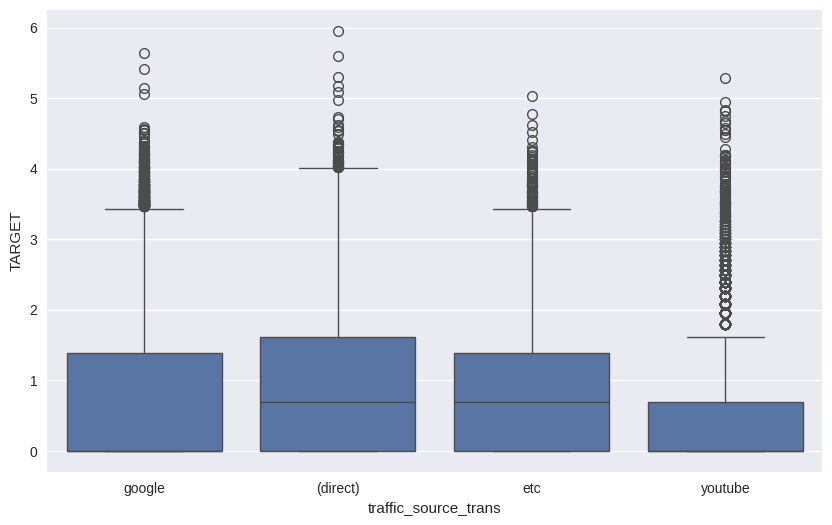

In [74]:
f, ax = plt.subplots(1,1, figsize = (10,6))

df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)

df2['traffic_source_trans'] = 'etc'
df2['traffic_source_trans'][df2['traffic_source']=='google'] = 'google'
df2['traffic_source_trans'][df2['traffic_source']=='(direct)'] = '(direct)'
df2['traffic_source_trans'][df2['traffic_source']=='youtube'] = 'youtube'
sns.boxplot(y='TARGET', x = 'traffic_source_trans', data = df2)

In [75]:
df2.groupby('traffic_source_trans')['TARGET'].agg(['mean','median'])

,mean,median
traffic_source_trans,,
(direct),0.969999,0.693147
etc,0.719957,0.693147
google,0.777767,0.000000
youtube,0.460898,0.000000


**Observations:**
* traffic_source는 168개의 범주로 이루어져 있음. 하지만, 그 중 google, (direct), youtube의 순서로 비율이 높음.
* 범주 내 google, youtube가 있는 경우 추출하고, google, youtube, direct 이외를 하나의 새로운 범주인 etc로 처리한 뒤 TARGET의 분포, 평균, 중앙값을 보면 다른 경향들을 나타내고 있음.

### **3.2.6 traffic_medium**
트래픽 소스의 매체

In [76]:
df_train['traffic_medium'].unique()

array(['organic', '(none)', 'affiliate', 'referral', 'cpc', 'cpm',
       '(not set)'], dtype=object)

In [77]:
len(df_train['traffic_medium'].unique())

7

In [78]:
df_train['traffic_medium'].value_counts(ascending=False)/df2.shape[0]

organic      0.425583
referral     0.277646
(none)       0.233946
cpc          0.039550
affiliate    0.021265
cpm          0.001986
(not set)    0.000024
Name: traffic_medium, dtype: float64

<Axes: xlabel='traffic_medium_trans', ylabel='TARGET'>

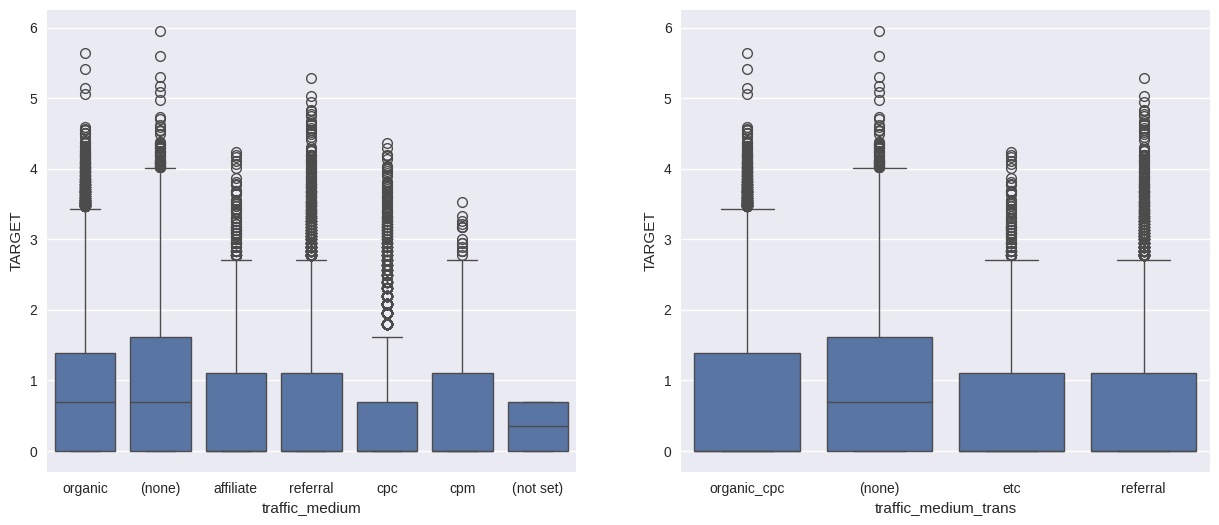

In [79]:
df2 = df_train.copy()

f, ax = plt.subplots(1,2, figsize = (15,6))

df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)
sns.boxplot(y='TARGET', x = 'traffic_medium', data = df2, ax = ax[0])

df2['traffic_medium_trans'] = 'etc'
df2['traffic_medium_trans'][df2['traffic_medium']=='organic'] = 'organic_cpc'
df2['traffic_medium_trans'][df2['traffic_medium']=='referral'] = 'referral'
df2['traffic_medium_trans'][df2['traffic_medium']=='(none)'] = '(none)'
df2['traffic_medium_trans'][df2['traffic_medium']=='cpc'] = 'organic_cpc'
sns.boxplot(y='TARGET', x = 'traffic_medium_trans', data = df2, ax = ax[1])

In [80]:
df2.groupby('traffic_medium_trans')['TARGET'].agg(['mean','median'])

,mean,median
traffic_medium_trans,,
(none),0.970065,0.693147
etc,0.648327,0.000000
organic_cpc,0.776562,0.000000
referral,0.531235,0.000000


**Observations:**
* traffic_medium feature는 7개의 범주로 이루어져 있음. 그 중 organic이 42.6%, referraldl 27.8%, (none)이 23.3%의 비율로 구성되어 있음.
* keyword feature가 organic과 cpc인 경우 부여되는 것이기 때문에 두 범주를 하나로 묶었고, referrel path feature가 referrel일 경우 부여되는 것이기 때문에 하나의 범주로 유지하였음. 추가적으로 (none)과 etc 범주까지 총 4개의 범주를 이용하여 TARGET의 데이터 분포, 평균, 중앙값을 확인하였을 때, 각각의 다른 분포와 값을 보임.

# **4. Feature Engineering**

## **4.1 수치형 데이터**
* Log 변환이 필요한 feature는 변환 후 정규화 처리 (MinMaxScaler) 진행
* Log 변환이 필요하지 않는 feature 정규화 처리 (MinMaxScaler)만 진행
* 0과 1로만 존재하는 feature는 미처리

### **4.1.1 Target**

In [81]:
# 로그 변환
df2 = df_train.copy()
# df2['TARGET'] = df2['TARGET'].map(lambda i : np.log(i) if i > 0 else 0)
df2['TARGET'] = df2['TARGET'].map(lambda i : np.log1p(i))

### **4.1.2 quality**

In [82]:
# 로그 변환
# df2['quality'] = df2['quality'].map(lambda i : np.log(i) if i > 0 else 0)
df2['quality'] = df2['quality'].map(lambda i : np.log1p(i))

# 정규화
from sklearn.preprocessing import MinMaxScaler
mms_quality = MinMaxScaler()
df2['quality'] = mms_quality.fit_transform(df2[['quality']])

### **4.1.3 duration**

In [83]:
# 로그 변환
# df2['duration'] = df2['duration'].map(lambda i : np.log(i) if i > 0 else 0)
df2['duration'] = df2['duration'].map(lambda i : np.log1p(i))

# 정규화
from sklearn.preprocessing import MinMaxScaler
mms_duration = MinMaxScaler()
df2['duration'] = mms_duration.fit_transform(df2[['duration']])

### **4.1.4 transaction**

In [84]:
# 정규화
from sklearn.preprocessing import MinMaxScaler
mms_transaction = MinMaxScaler()
df2['transaction'] = mms_transaction.fit_transform(df2[['transaction']])

### **4.1.7 transaction_revenue**

In [85]:
# 로그 변환
# df2['transaction_revenue'] = df2['transaction_revenue'].map(lambda i : np.log(i) if i > 0 else 0)
df2['transaction_revenue'] = df2['transaction_revenue'].map(lambda i : np.log1p(i))

# 정규화
from sklearn.preprocessing import MinMaxScaler
mms_transaction_revenue = MinMaxScaler()
df2['transaction_revenue'] = mms_transaction_revenue.fit_transform(df2[['transaction_revenue']])

## **4.2 범주형 데이터**
* 범주 통합: One-hot encoding 처리 이전에 범주의 수를 축소시키는 과정
* One-hot encoding: pd.get_dummies()를 이용하여 One-hot encoding 진행
* Country 및 subcontinent는 contient의 큰 범주로 축소시키기 위해 삭제

### **4.2.1 browser**

In [86]:
# 범주 통합 및 One-hot Encoding
df2['browser_num'] = 0
df2['browser_num'][df2['browser']=='Chrome'] = 1
df2 = df2.drop('browser', axis = 1)

### **4.2.2 OS**

In [87]:
# 범주 통합
df2['OS_trans'] = 'etc'
df2['OS_trans'][df2['OS']=='Windows'] = 'not_Macintosh'
df2['OS_trans'][df2['OS']=='Macintosh'] = 'Macintosh'
df2['OS_trans'][df2['OS']=='Android'] = 'not_Macintosh'
df2['OS_trans'][df2['OS']=='iOS'] = 'not_Macintosh'

# One-hot Encoding
df2 = pd.get_dummies(df2, columns = ['OS_trans'])
df2 = df2.drop('OS', axis = 1)
df2 = df2.drop('OS_trans_etc', axis = 1)

### **4.2.3 device**

In [88]:
# 범주 통합
df2['device_trans'] = 'not_desktop'
df2['device_trans'][df2['device']=='desktop'] = 'desktop'

# One-hot Encoding
df2 = pd.get_dummies(df2, columns = ['device_trans'])
df2 = df2.drop('device', axis = 1)
df2 = df2.drop('device_trans_not_desktop', axis = 1)

### **4.2.4 continent**

In [89]:
# 범주 통합
df2['continent_trans'] = 'etc'
df2['continent_trans'][df2['continent']=='Americas'] = 'Americas'
df2['continent_trans'][df2['continent']=='Asia'] = 'Eurasia'
df2['continent_trans'][df2['continent']=='Europe'] = 'Eurasia'

# One-hot Encoding
df2 = pd.get_dummies(df2, columns = ['continent_trans'])
df2 = df2.drop('continent', axis = 1)
df2 = df2.drop('continent_trans_etc', axis = 1)

### **4.2.5 traffic_source**

In [90]:
# 범주 통합
df2['traffic_source_trans'] = 'etc'
df2['traffic_source_trans'][df2['traffic_source']=='google'] = 'google'
df2['traffic_source_trans'][df2['traffic_source']=='(direct)'] = '(direct)'
df2['traffic_source_trans'][df2['traffic_source']=='youtube'] = 'youtube'

# One-hot Encoding
df2 = pd.get_dummies(df2, columns = ['traffic_source_trans'])
df2 = df2.drop('traffic_source', axis = 1)
df2 = df2.drop('traffic_source_trans_etc', axis = 1)

### **4.2.6 traffic_medium**

In [91]:
# 범주 통합
df2['traffic_medium_trans'] = 'etc'
df2['traffic_medium_trans'][df2['traffic_medium']=='organic'] = 'organic_cpc'
df2['traffic_medium_trans'][df2['traffic_medium']=='referral'] = 'referral'
df2['traffic_medium_trans'][df2['traffic_medium']=='(none)'] = '(none)'
df2['traffic_medium_trans'][df2['traffic_medium']=='cpc'] = 'organic_cpc'

# One-hot Encoding
df2 = pd.get_dummies(df2, columns = ['traffic_medium_trans'])
df2 = df2.drop('traffic_medium_trans_etc', axis = 1)

### **4.2.7 keyword**
* keyword가 존재하는 경우 (traffic_medium이 organic과 cpc)와 아닌 경우로 나눔

In [92]:
# 범주 통합 및 One-hot Encoding
df2['keyword_num'] = 0
df2['keyword_num'][df2['traffic_medium']=='organic'] = 1
df2['keyword_num'][df2['traffic_medium']=='cpc'] = 1
df2 = df2.drop('keyword', axis = 1)

### **4.2.8 referral_path**
* referral_path가 존재하는 경우 (traffic_medium이 referral)와 아닌 경우로 나눔

In [93]:
# 범주 통합 및 One-hot Encoding
df2['referral_path_num'] = 0
df2['referral_path_num'][df2['traffic_medium']=='referral'] = 1
df2 = df2.drop('referral_path', axis = 1)

### **4.2.7 Drop columns**

In [94]:
df2 = df2.drop('sessionID', axis = 1)
df2 = df2.drop('userID', axis = 1)
df2 = df2.drop('subcontinent', axis =1)
df2 = df2.drop('country', axis = 1)
df2 = df2.drop('traffic_medium', axis = 1)

## **4.3 시험(test) 데이터**

In [95]:
df_test2 = df_test.copy()

# quality
## 로그 변환
# df_test2['quality'] = df_test2['quality'].map(lambda i : np.log(i) if i > 0 else 0)
df_test2['quality'] = df_test2['quality'].map(lambda i : np.log1p(i))
## 정규화
df_test2['quality'] = mms_quality.transform(df_test2[['quality']])

# duraction
## 로그 변환
# df_test2['duration'] = df_test2['duration'].map(lambda i : np.log(i) if i > 0 else 0)
df_test2['duration'] = df_test2['duration'].map(lambda i : np.log1p(i))
## 정규화
df_test2['duration'] = mms_duration.transform(df_test2[['duration']])

# transaction
## 정규화
df_test2['transaction'] = mms_transaction.transform(df_test2[['transaction']])

# transaction_revenue
## 로그 변환
# df_test2['transaction_revenue'] = df_test2['transaction_revenue'].map(lambda i : np.log(i) if i > 0 else 0)
df_test2['transaction_revenue'] = df_test2['transaction_revenue'].map(lambda i : np.log1p(i))
## 정규화
df_test2['transaction_revenue'] = mms_transaction_revenue.transform(df_test2[['transaction_revenue']])

# browser
# 범주 통합 및 One-hot Encoding
df_test2['browser_num'] = 0
df_test2['browser_num'][df_test2['browser']=='Chrome'] = 1
df_test2 = df_test2.drop('browser', axis = 1)

# OS
## 범주 통합
df_test2['OS_trans'] = 'etc'
df_test2['OS_trans'][df_test2['OS']=='Windows'] = 'not_Macintosh'
df_test2['OS_trans'][df_test2['OS']=='Macintosh'] = 'Macintosh'
df_test2['OS_trans'][df_test2['OS']=='Android'] = 'not_Macintosh'
df_test2['OS_trans'][df_test2['OS']=='iOS'] = 'not_Macintosh'
## One-hot Encoding
df_test2 = pd.get_dummies(df_test2, columns = ['OS_trans'])
df_test2 = df_test2.drop('OS', axis = 1)
df_test2 = df_test2.drop('OS_trans_etc', axis = 1)

# device
## 범주 통합
df_test2['device_trans'] = 'not_desktop'
df_test2['device_trans'][df_test2['device']=='desktop'] = 'desktop'
## One-hot Encoding
df_test2 = pd.get_dummies(df_test2, columns = ['device_trans'])
df_test2 = df_test2.drop('device', axis = 1)
df_test2 = df_test2.drop('device_trans_not_desktop', axis = 1)

# continent
## 범주 통합
df_test2['continent_trans'] = 'etc'
df_test2['continent_trans'][df_test2['continent']=='Americas'] = 'Americas'
df_test2['continent_trans'][df_test2['continent']=='Asia'] = 'Eurasia'
df_test2['continent_trans'][df_test2['continent']=='Europe'] = 'Eurasia'
## One-hot Encoding
df_test2 = pd.get_dummies(df_test2, columns = ['continent_trans'])
df_test2 = df_test2.drop('continent', axis = 1)
df_test2 = df_test2.drop('continent_trans_etc', axis = 1)

# traffic_source
## 범주 통합
df_test2['traffic_source_trans'] = 'etc'
df_test2['traffic_source_trans'][df_test2['traffic_source']=='google'] = 'google'
df_test2['traffic_source_trans'][df_test2['traffic_source']=='(direct)'] = '(direct)'
df_test2['traffic_source_trans'][df_test2['traffic_source']=='youtube'] = 'youtube'
## One-hot Encoding
df_test2 = pd.get_dummies(df_test2, columns = ['traffic_source_trans'])
df_test2 = df_test2.drop('traffic_source', axis = 1)
df_test2 = df_test2.drop('traffic_source_trans_etc', axis = 1)

# traffic_medium
## 범주 통합
df_test2['traffic_medium_trans'] = 'etc'
df_test2['traffic_medium_trans'][df_test2['traffic_medium']=='organic'] = 'organic_cpc'
df_test2['traffic_medium_trans'][df_test2['traffic_medium']=='referral'] = 'referral'
df_test2['traffic_medium_trans'][df_test2['traffic_medium']=='(none)'] = '(none)'
df_test2['traffic_medium_trans'][df_test2['traffic_medium']=='cpc'] = 'organic_cpc'
## One-hot Encoding
df_test2 = pd.get_dummies(df_test2, columns = ['traffic_medium_trans'])
df_test2 = df_test2.drop('traffic_medium_trans_etc', axis = 1)

# keyword
# 범주 통합 및 One-hot Encoding
df_test2['keyword_num'] = 0
df_test2['keyword_num'][df_test2['traffic_medium']=='organic'] = 1
df_test2['keyword_num'][df_test2['traffic_medium']=='cpc'] = 1
df_test2 = df_test2.drop('keyword', axis = 1)

# referral_path
# 범주 통합 및 One-hot Encoding
df_test2['referral_path_num'] = 0
df_test2['referral_path_num'][df_test2['traffic_medium']=='referral'] = 1
df_test2 = df_test2.drop('referral_path', axis = 1)

# drop columns
df_test2 = df_test2.drop('sessionID', axis = 1)
df_test2 = df_test2.drop('userID', axis = 1)
df_test2 = df_test2.drop('subcontinent', axis =1)
df_test2 = df_test2.drop('country', axis = 1)
df_test2 = df_test2.drop('traffic_medium', axis = 1)

# **5. Modeling**

## **5.0 Data Split**
train data를 X_train, X_test, y_train, y_test로 분리하여 모델 구축

In [96]:
from sklearn.model_selection import train_test_split
y = df2['TARGET']
df2 = df2.drop('TARGET', axis = 1)
X = df2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [97]:
simple_model = ['LinearRegression', 'Ridge', 'DecisionTreeRegressor', 'AdaBoostRegressor', 'XGBRegressor']
simple_rmse = []

In [98]:
# RMSE 계산 함수 정의
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return(np.sqrt(mse))

## **5.1 Simeple Modeling**

### **5.1 LinearRegression**

In [99]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
rmse_lr = rmse(y_test, pred_lr)
simple_rmse.append(rmse_lr)
print(f'LinearRegression rmse: {rmse_lr}')

LinearRegression rmse: 0.26075732816762187


### **5.2 Ridge**


In [100]:
from sklearn.linear_model import Ridge

rid = Ridge(alpha = 0.01, random_state = 0)
rid.fit(X_train, y_train)
pred_rid = rid.predict(X_test)
rmse_rid = rmse(y_test, pred_rid)
simple_rmse.append(rmse_rid)
print(f'Ridge rmse: {rmse_rid}')

Ridge rmse: 0.2607496752826249


### **5.3 DecisionTreeRegressor**

In [101]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state = 0)
dtr.fit(X_train, y_train)
pred_dtr = dtr.predict(X_test)
rmse_dtr = rmse(y_test, pred_dtr)
simple_rmse.append(rmse_dtr)
print(f'DecisionTreeRegressor rmse: {rmse_dtr}')

DecisionTreeRegressor rmse: 0.2516457180896645


### **5.4 AdaBoostRegressor**

In [102]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state = 0)
ada.fit(X_train, y_train)
pred_ada = ada.predict(X_test)
rmse_ada = rmse(y_test, pred_ada)
simple_rmse.append(rmse_ada)
print(f'DecisionTreeRegressor rmse: {rmse_ada}')

DecisionTreeRegressor rmse: 0.2712757468792615


### **5.5 XGBRegressor**

In [103]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state = 0)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
rmse_xgb = rmse(y_test, pred_xgb)
simple_rmse.append(rmse_xgb)
print(f'XGBRegressor rmse: {rmse_xgb}')

XGBRegressor rmse: 0.20223567624126626


In [104]:
df_simple = pd.DataFrame({'Model': simple_model, 'RMSE': simple_rmse})
df_simple

,Model,RMSE
0,LinearRegression,0.260757
1,Ridge,0.260750
2,DecisionTreeRegressor,0.251646
3,AdaBoostRegressor,0.271276
4,XGBRegressor,0.202236


**Summary:**
* 각 파라미터 설정없이 모델을 구축 및 적용하였고, 각 모델의 성능을 RMSE로 평가함. 다른 모델에 비해 XGBRegressor가 가장 좋은 성능을 보임.

## **5.2 Hyperparameter Tuning**
* Simple Model section에서 가장 좋은 성능을 보인 XGBRegressor의 성능을 추가로 개선

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

xgb1 = XGBRegressor(random_state = 0)
parameters = {
              'eta': [0.01, 0.05, 0.1],
              'max_depth': [4, 6, 8],
              'colsample_bytree': [0.5, 0.7, 0.9],
              'n_estimators': [300, 500, 1000],
              'gamma': [0.3, 0.6, 0.9],
              }

rmse_score = make_scorer(rmse, greater_is_better=False)

xgb_grid = GridSearchCV(xgb1,param_grid = parameters, scoring = rmse_score ,cv = 2, n_jobs = 5, verbose=True)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
pred_xgb_best = xgb_best.predict(X_test)
rmse_xgb_best = rmse(y_test, pred_xgb_best)
print(f'XGBRegressor rmse: {rmse_xgb_best}')

Fitting 2 folds for each of 243 candidates, totalling 486 fits
XGBRegressor rmse: 0.20113116376251242


In [137]:
xgb_grid.best_params_

{'colsample_bytree': 0.9,
 'eta': 0.05,
 'gamma': 0.3,
 'max_depth': 8,
 'n_estimators': 300}

**Summary:**
* GridSearchCV를 통해 XGBRegressor의 최적 파라미터를 찾았고, 그 파타미터를 포함한 최적 모델의 성능을 평가한 결과 RMSE값이 Simple model 대비 소폭 개선됨.
* XGBRegressor 모델의 파라미터를 개선하여 RMSE를 개선하는 것은 한계가 있어보이며, 추가적인 성능 개선을 위해서는 feature에 대한 전처리 방법에 대한 고민이 필요해 보임.

# **6. Prediction**

In [138]:
submission_df = pd.read_csv('data/open/sample_submission.csv')

final_answer = xgb_best.predict(df_test2)
submission_df['TARGET'] = np.expm1(final_answer)
submission_df.to_csv('data/open/submission.csv', index=False)

In [107]:
submission_df.head()

,sessionID,TARGET
0,SESSION_252289,25.454453
1,SESSION_252290,0.998229
2,SESSION_252291,2.729723
3,SESSION_252292,3.961344
4,SESSION_252293,8.457928
